# IRM with data scaling

Even with hyperparameter search, our resulting networks are unstable across training runs. This is probably because the features have large and different domains. Let's scale both features and target to a smaller range and see how we do.

In [227]:
import pandas as pd
import numpy as np

import torch

from torch import nn, optim, autograd
from torch.nn import functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ax import optimize

Restrict to one year. There is nothing in the data to account for the growth of bike sharing from one year to the next.

In [228]:
df = pd.read_csv('../../../data/Bike-Sharing-Dataset/hour.csv')
df = df[df.yr == 0]

In [229]:
day_dummies = pd.get_dummies(df['weekday'])
day_dummies.columns = ['sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat']

In [230]:
weather_dummies = pd.get_dummies(df['weathersit'], drop_first=True)
weather_dummies.columns = ['misty', 'rainy', 'snowy']

In [231]:
features = [
    'holiday', 'workingday',
    'sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'hr',
    'misty', 'rainy', 'snowy',
    'temp', 'atemp', 'hum', 'windspeed'
]

In [232]:
environment = ['season']

In [233]:
target = ['cnt']

In [234]:
df_ = (
    df
    .merge(weather_dummies, left_index=True, right_index=True)
    .merge(day_dummies, left_index=True, right_index=True)
    [features + environment + target]
)

The net architecture is pretty arbitrary.

In [235]:
class NN(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(NN, self).__init__()
        self.hidden1 = nn.Linear(n_features, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [236]:
mse = nn.MSELoss(reduction='mean')

In [375]:
def penalty(predictions, targets):
    dummy = torch.tensor(1., requires_grad=True)
    loss = mse(predictions * dummy, targets)
    grad = autograd.grad(loss, dummy, create_graph=True)[0]
    squared_grad_norm = (grad**2).sum()
    return squared_grad_norm

Define our environments. The pooled environment is to attack the problem from a usual "this is what we do in supervised learning" angle.

In [352]:
winter_df = df_[df_.season == 1]
fall_df = df_[df_.season == 4]
spring_df = df_[df_.season == 2]
summer_df = df_[df_.season == 3]

pooled_df = pd.concat([spring_df, summer_df, winter_df])

pooled_df_train, pooled_df_test = train_test_split(pooled_df, test_size=0.33, shuffle=True)

In [353]:
feature_scaler = StandardScaler().fit(pooled_df_train[features])
target_scaler = StandardScaler().fit(pooled_df_train[target])

In [354]:
def construct_env(df):
    return {
        'features': torch.Tensor(feature_scaler.transform(df[features].to_numpy())),
        'target': torch.Tensor(target_scaler.transform(df[target].to_numpy()))
    }

In [355]:
winter = construct_env(winter_df)
fall = construct_env(fall_df)
spring = construct_env(spring_df)
summer = construct_env(summer_df)

pooled_train = construct_env(pooled_df_train)
pooled_test = construct_env(pooled_df_test)

In [356]:
N_FEATURES = winter['features'].shape[1]

Pretty naive early stopping. Sample the test set MSE every hundred epochs. If it gets worse twice consecutively, stop and keep the last model. Should really keep the third last model, or else track a history of performance and choose the best.

In [357]:
def fit_model(hidden_dim, learning_rate):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    errs = [np.inf, np.inf]
    for iteration in range(5000):
        preds = net(pooled_train['features'])
        err = mse(preds, pooled_train['target'])
        
        opt.zero_grad()
        err.backward()
        opt.step()
        
        if iteration % 100 == 0:
            errs.append(
                mse(
                    net(pooled_test['features']), pooled_test['target']
                )
            )
            errs = errs[-3:]
        
            # early stopping - stop if validation error increases
            if errs[-3] <= errs[-2] <= errs[-1]:
                break
    
    return net

In [358]:
def fit_evaluate(hidden_dim, learning_rate):
    net = fit_model(hidden_dim, learning_rate)    
    return mse(net(pooled_test['features']), pooled_test['target']).item()

Perform Bayesian optimization for hyperparameter tuning. There's a risk of overfitting to the test set here but we'll live with it.

In [359]:
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {
            'name': 'hidden_dim',
            'type': 'range',
            'value_type': 'int',
            'bounds': [1, 20]
        },
        {
            'name': 'learning_rate',
            'type': 'range',
            'value_type': 'float',
            'bounds': [1e-4, 1e-1]
        },
    ],
    evaluation_function = lambda p: fit_evaluate(
        p['hidden_dim'], p['learning_rate']
    ),
    minimize=True,
    total_trials=20
)

[INFO 03-09 12:52:16] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 12:52:16] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 12:52:16] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-09 12:52:17] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-09 12:52:20] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-09 12:52:21] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-09 12:52:23] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-09 12:52:25] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-09 12:52:28] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-09 12:52:34] ax.service.managed_loop: Running optimization t

In [360]:
best_values

({'objective': 0.08982471177315007},
 {'objective': {'objective': 1.2891107695365607e-09}})

In [361]:
best_parameters

{'hidden_dim': 19, 'learning_rate': 0.06873016830219057}

Having chosen the best hyperparams, re-fit the net with them. In principle we should be able to wire Ax up to return the best model (I think?).

In [362]:
best_net = fit_model(best_parameters['hidden_dim'], best_parameters['learning_rate'])

Plot predictions vs ground truth on train, test and holdout sets.

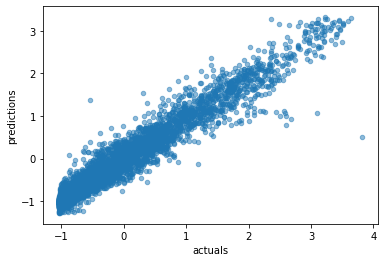

In [370]:
(
    pd.DataFrame({
        'predictions': best_net(pooled_train['features']).squeeze().tolist(),
        'actuals': pooled_train['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5
    )
)

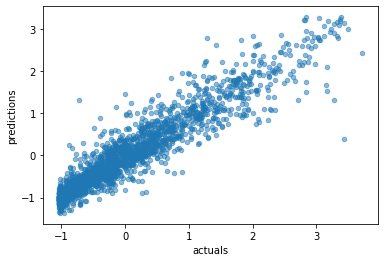

In [371]:
(
    pd.DataFrame({
        'predictions': best_net(pooled_test['features']).squeeze().tolist(),
        'actuals': pooled_test['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
    )
)

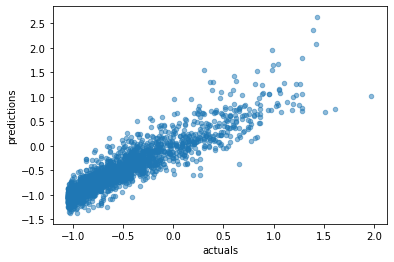

In [372]:
(
    pd.DataFrame({
        'predictions': best_net(winter['features']).squeeze().tolist(),
        'actuals': winter['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
    )
)

The MSE on the holdout set should be smaller than train/test, even if the model is not well suited to it, because in winter there are fewer rentals, so given the same predictive power, the raw value of the errors is smaller. We could compare performance with train/test using some sort of scaled error, but what we're really interested in is the comparison with IRM.

In [373]:
mse(best_net(winter['features']), winter['target']).item()

0.04674621671438217

## Once more, with IRM

In [376]:
def fit_irm(hidden_dim, learning_rate, n_wait, scale):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    env1 = spring.copy()
    env2 = summer.copy()
    errs = [np.inf, np.inf]
    
    for iteration in range(5000):
        for env in [env1, env2]:
            preds = net(env['features'])
            env['error'] = mse(preds, env['target'])
            env['penalty'] = penalty(preds, env['target'])
        
        train_error = torch.stack([env1['error'], env2['error']]).mean()
        train_penalty = torch.stack([env1['penalty'], env2['penalty']]).mean()

        if iteration < n_wait:
            loss = train_error
        else:
            loss = (train_error + scale * train_penalty)
            loss /= scale
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if (iteration % 100 == 0) & (iteration > n_wait):
            errs.append(mse(net(pooled_test['features']), pooled_test['target']))
                    
            # early stopping - stop if validation error increases
            if errs[-3] <= errs[-2] <= errs[-1]:
                break
    
    return net

In [377]:
def fit_evaluate_irm(hidden_dim, learning_rate, n_wait, scale):
    net = fit_irm(hidden_dim, learning_rate, n_wait, scale)
    return mse(net(pooled_test['features']), pooled_test['target']).item()

As before, but we have more parameters to search over.

In [378]:
irm_best_parameters, irm_best_values, irm_experiment, irm_model = optimize(
    parameters=[
        {
            'name': 'hidden_dim',
            'type': 'range',
            'value_type': 'int',
            'bounds': [1, 20]
        },
        {
            'name': 'learning_rate',
            'type': 'range',
            'value_type': 'float',
            'bounds': [1e-4, 1e-1]
        },
        {
            'name': 'n_wait',
            'type': 'range',
            'value_type': 'int',
            'bounds': [1, 1e3]
        },
        {
            'name': 'scale',
            'type': 'range',
            'value_type': 'float',
            'bounds': [1., 1e8]
        }
    ],
    evaluation_function = lambda p: fit_evaluate_irm(
        p['hidden_dim'], p['learning_rate'], p['n_wait'], p['scale']
    ),
    minimize=True,
    total_trials=20
)

[INFO 03-09 12:54:24] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-09 12:54:24] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-09 12:54:24] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-09 12:54:27] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-09 12:54:28] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-09 12:54:37] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-09 12:54:39] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-09 12:54:51] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-09 12:55:06] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-09 12:55:10] ax.service.managed_loop: Running optimization t

In [385]:
irm_best_parameters

{'hidden_dim': 18,
 'learning_rate': 0.0001,
 'n_wait': 1000,
 'scale': 27419972.265809625}

In [386]:
irm_best_values

({'objective': 0.5856763452207777},
 {'objective': {'objective': 2.4355282976006535e-09}})

In [387]:
best_irm_net = fit_irm(
    irm_best_parameters['hidden_dim'],
    irm_best_parameters['learning_rate'],
    irm_best_parameters['n_wait'],
    irm_best_parameters['scale']
)

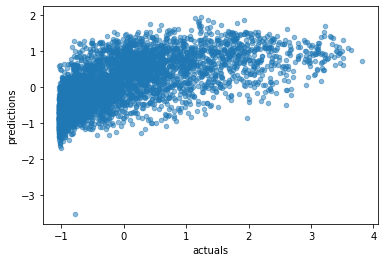

In [388]:
(
    pd.DataFrame({
        'predictions': best_irm_net(pooled_train['features']).squeeze().tolist(),
        'actuals': pooled_train['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5
    )
)

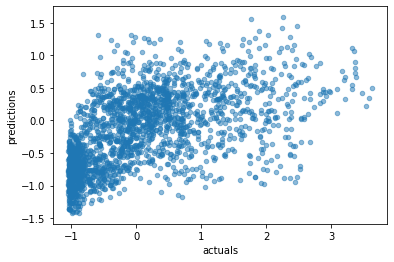

In [389]:
(
    pd.DataFrame({
        'predictions': best_irm_net(fall['features']).squeeze().tolist(),
        'actuals': fall['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
    )
)

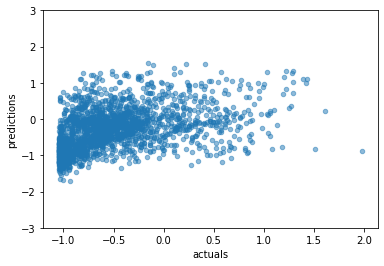

In [390]:
# irm validation set

(
    pd.DataFrame({
        'predictions': best_irm_net(winter['features']).squeeze().tolist(),
        'actuals': winter['target'].squeeze().tolist()
    }).plot(
        x='actuals',
        y='predictions',
        kind='scatter',
        alpha=0.5,
        ylim=(-3, 3)
    )
)

Performance of IRM kinda sucks. Seems the invariance penalty is inhibiting learning. It's definitely not clear that even a net that is well trained with IRM could substantially outperform regular supervised learning, because the supervised predictor above doesn't suck on the hold out set like we thought it might.

In [391]:
print('rmse of non-IRM model on non-IRM test set:', np.sqrt(best_values[0]['objective']))

rmse of non-IRM model on non-IRM test set: 0.2997077105667288


In [395]:
print('rmse of IRM model on non-IRM test set:',np.sqrt(irm_best_values[0]['objective']))

rmse of IRM model on non-IRM test set: 0.7652949400203674


In [396]:
print('rmse of non-IRM on holdout winter season:', np.sqrt(mse(best_net(winter['features']), winter['target']).item()))

rmse of non-IRM on holdout winter season: 0.2162087341306594


In [397]:
print('rmse of IRM on holdout winter season:', np.sqrt(mse(best_irm_net(winter['features']), winter['target']).item()))

rmse of IRM on holdout winter season: 0.608490522099251
